# Google Trends in Bangladesh

In [13]:
import os, sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
from datetime import datetime as dt
import geopandas as gpd

from googleapiclient.discovery import build
from googleapiclient.http import HttpError

# from credentials import get_key

In [14]:
import os
API_KEY = os.environ.get('API_GOOGLE_TRENDS')  # Using .get() to avoid KeyError

We ensure API connection

The general purpose of this code is to provide a Google class that acts as a wrapper to interact with the Google API, specifically designed to perform authentication and GET requests to the Google Trends service. It allows accessing API methods, such as **getGraph** and **getTimelinesForHealth**, processing the data obtained in JSON format, converting them into a DataFrame with the **pandas** library and exporting them as CSV files for easy analysis. In addition, it includes functionalities to handle authentication through an API token and encapsulates the API interaction logic to simplify its use in custom applications.

In [15]:
# pip install python-dotenv

In [16]:
class Google():
    """
    Wrapper class for handling authentication and requests (GET) to Google API

    Parameters
    ----------
    token : str
        Google API token

    Notes
    -----
    For more information, please see https://developers.google.com/apis-explorer
    """
    def __init__(self, token=None):
        self.TOKEN = token if token else os.environ.get('API_GOOGLE_TRENDS')
        self._service = None

    @property
    def service(self):
        """Authenticate and instantiate Google API service"""
        return build('trends', 'v1beta', static_discovery=False, developerKey=self.TOKEN)

    def get(self, method, params):
        """Get result from Google API method"""
        return getattr(self.service, method)(**params).execute()


    def download(self, method, params):
        """Download result from Google API method"""

        if not method in ["getGraph", "getTimelinesForHealth"]:
            raise NotImplementedError("Method not supported.")

        result = self.get(method, params)

        df = pd.json_normalize(result["lines"], meta=["term"], record_path=["points"])

        params = "+".join([f"{k}={v}" for k, v in params.items()])
        name = f"{method}+{params}.csv"

        df.to_csv(name, index=False)

In [17]:
API_KEY = os.environ.get('API_GOOGLE_TRENDS')
google = Google(API_KEY)  # Use API_KEY directly instead of get_key()

For the purpose of this analysis, we’ve broken down search terms into six major categories. These categories broadly caputre people’s interest over time and provides high level insights into their behavior. These categories include:

*   Exchange Rate
*   Devaluation
*   Prices
*   Natural Disasters
*   Conflicts
*   Other relevant terms

These terms have been collected from Google’s related terms and topics search, as well as brainstorming with the team.

## Topic based search

In [25]:
forex_terms = {"Exchange Rate": ["bangladeshi immigration", 'bangladeshi birr', "bangladeshi black market", "National Bank of Bangladesh",
               "Central Bank of Bangladesh", "BRAC Bank exchange rate",
            "Dutch-Bangla Bank Limited exchange rate", "national bank of bangladesh exchange rate", "gold price in bangladesh"]}

deval_terms = {"Devaluation" : ["GDP per capita", "inflation rate "]}

price_terms = {"Prices" : ["fuel price in bangladesh", "fuel price", "gasoline price", "gold price", "gold price in bangladesh",
               "silver price in bangladesh"]}

disaster_terms = {"Natural Disasters" : ["earthquake", "landslides", "floods"]}

conflict_terms = {
    "Conflict": [
        "Sheikh Hasina",         
        "student protest", 
        "bangladesh quota protest",       
        "violence in bangladesh",    
        "labor strikes Bangladesh",        
    ]
}

other_terms = {"The urban redevelopment plan" : ["Old Dhaka"]}  

In [26]:
df = pd.DataFrame()

for dicts in [forex_terms, deval_terms, price_terms, disaster_terms, conflict_terms, other_terms]:

    for topic, lis in dicts.items():
        for term in lis:
            filters = {
                        'terms': term,
                        'restrictions_geo': "BD", 
                        'restrictions_startDate': "2024-01", 
                        'restrictions_endDate' : "2024-10" 
                    }

            r = google.get('getGraph', filters)

            df_ = pd.DataFrame(r['lines'][0]['points'])
            df_['term'] = term
            df_['topic'] = topic

            df = pd.concat([df, df_])

In [27]:
def get_topic_charts(df, topic):
    """"
    Function to create plots for a selected topic

    Inputs:
    df : pandas dataframe with Google's data from API
    tpoic : topic to plot data for

    Returns
    None
    """

    dftemp = df.query(f"topic == '{topic}'")
    dftemp.date = dftemp.date.apply(pd.to_datetime)
    dftemp = dftemp.pivot(index = 'date', columns = 'term', values = 'value')

    for cols in dftemp.columns:
        if len(dftemp[cols].unique()) == 1:
            del dftemp[cols]


    fig, ax = plt.subplots(1, 1)
    dftemp.plot(ax = ax, figsize = (15, 8))
    if topic == "Conflict":
        ax.axvline(pd.Timestamp('2024-08-05'),color='r', ls = '-.', lw = 2, label = "Uncontrolled protests") #Estas etiquetas corresponden para el caso de Etipia. CAMBIAR
    elif topic == "Natural Disasters":
        pass
    else:
        ax.axvline(pd.Timestamp('2024-08-05'),color='r', ls = '-.', lw = 2, label = "Uncontrolled protests") # Ajustado al caso de Bangladesh
    plt.legend()
    plt.ylabel("Normalized search score", fontsize = 10);
    plt.xlabel('')
    ax.set_title(f"Relative Google Search Trends for {topic} related terms", fontsize = 12);

## Conflict Related Terms

### Key Conclusions from Google Trends Data on Protests in Bangladesh

1. **Heightened Public Attention in August**: The data shows significant spikes in search interest for "violence in Bangladesh," "student protest," and "Sheikh Hasina" in August, aligning with a period of major political unrest and protests.

2. **Prime Minister's Resignation as a Turning Point**: The vertical line indicating the announcement of the Prime Minister's resignation marks a critical event that likely intensified public and media interest in the ongoing protests.

3. **Focus on Political Leadership and Civil Unrest**: Sustained interest in "Sheikh Hasina" throughout the year underscores the central role of political leadership in the discourse surrounding protests and unrest in Bangladesh.


C:\Users\Alexander\AppData\Local\Temp\ipykernel_42088\3208693226.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftemp.date = dftemp.date.apply(pd.to_datetime)


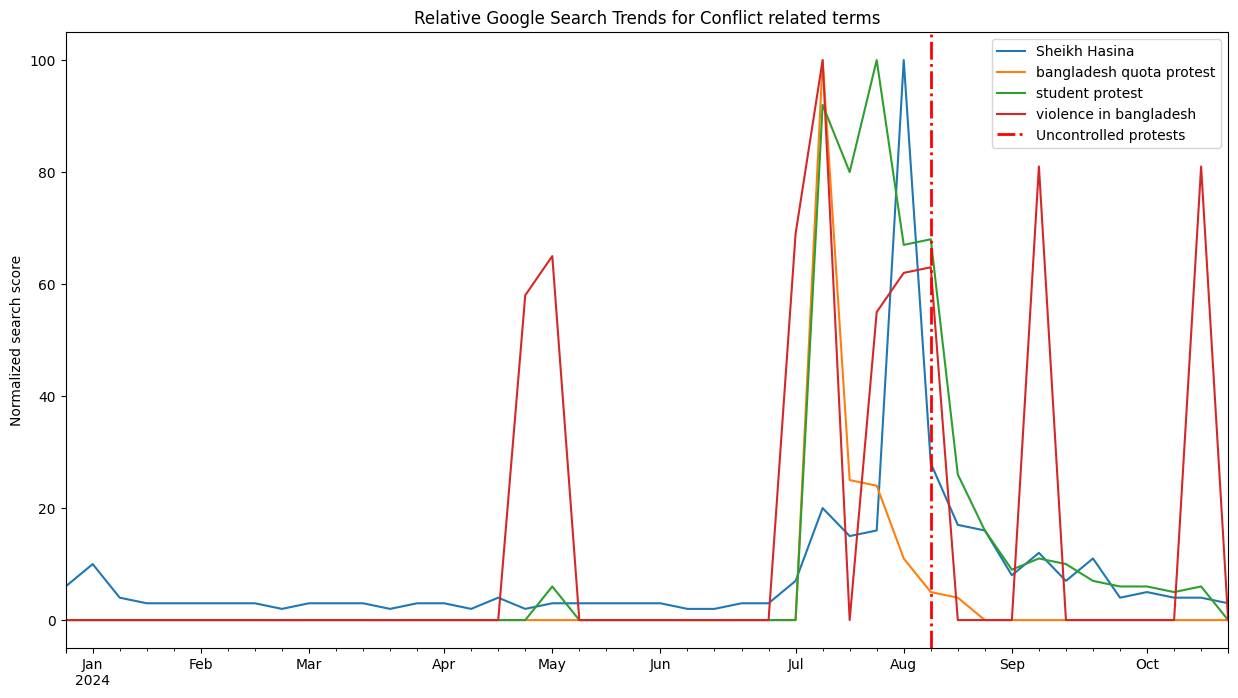

In [38]:
get_topic_charts(df, "Conflict")

## GDP Related Terms

This graph provides insight into how Google searches around devaluation-related topics in Bangladesh fluctuated throughout 2024. The volatility across all three terms suggests significant economic and political developments impacting the country during this period.

**Key observations:**

* The GDP per capita and inflation rate trends show significant volatility throughout the year, with sharp spikes and drops in search activity.

* The GDP per capita and inflation rate searches appear to be closely correlated, suggesting the public is searching for information on the economic situation and its impact.

C:\Users\Alexander\AppData\Local\Temp\ipykernel_42088\3208693226.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftemp.date = dftemp.date.apply(pd.to_datetime)


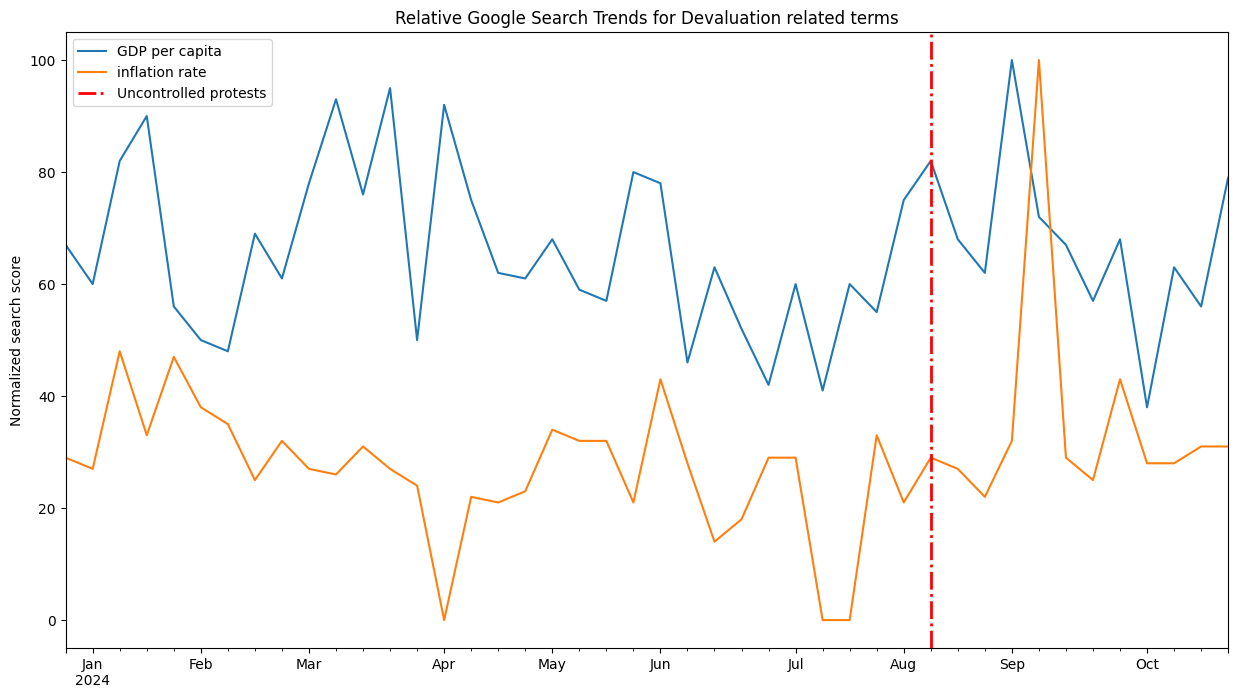

In [39]:
get_topic_charts(df, "Devaluation")

## Exchange Rate related Terms

This section uses the data gatehred from Google’s API and creates charts to see the trends for each of the search terms. In cases where its relevant, the benchmarking lines are shown for when FX market liberalization was annnounced and when Somaliland agreed to lease land to Ethiopia to build a naval facility.

For the topics **Exchange rate**, **Devaluation** and **Prices** - we can see sharp increase in the search for July 28th 2024, which was the date when market liberalization news first came out. People were inersted in knowing the more about devaluation and what it meant for the economy.

The graph represents the normalized search volume for each term over time. A higher search score indicates an increase in the number of Google searches for that specific term.

**Key insights from the graph:**

**Search Spikes:** Significant search activity is observed for terms like "BRAC Bank exchange rate," "Central Bank of Bangladesh," and "Bangladeshi immigration" around the middle of the year.

**Volatility:** The search trends for most terms are characterized by sharp fluctuations, with noticeable rises and declines throughout the year.

**Stability:** "Gold price in Bangladesh" and "National Bank of Bangladesh" exhibit relatively steady and lower search volumes compared to other terms, indicating less variation in public interest.

C:\Users\Alexander\AppData\Local\Temp\ipykernel_42088\3208693226.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftemp.date = dftemp.date.apply(pd.to_datetime)


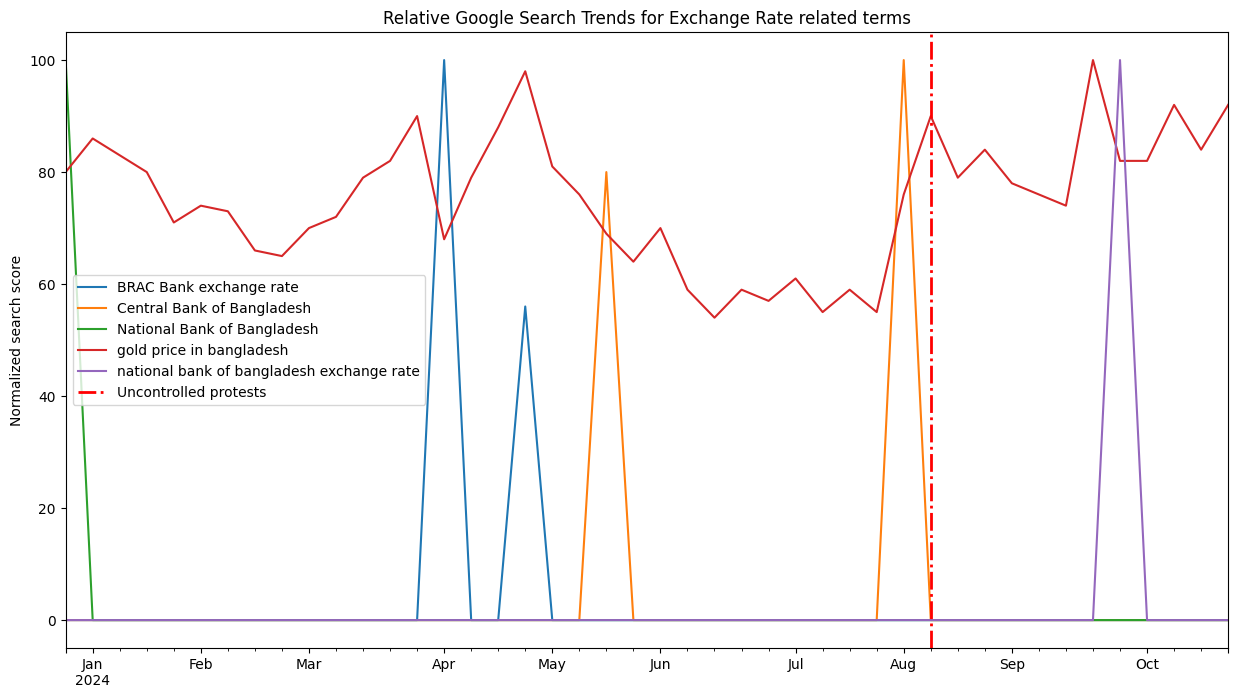

In [28]:
get_topic_charts(df, "Exchange Rate")

## Prices Related Terms

The fluctuations seen in these price-related terms suggest that Bangladesh likely faced significant economic events or disruptions affecting the cost of living during this period. The spike in searches for "Uncontrolled protests" could reflect public unrest or reactions to these price changes.

**Key observations:**

* The search trends for fuel prices, both globally and in Bangladesh, show considerable volatility throughout the year, with several sharp increases and decreases.

* The prices of gold (globally and in Bangladesh) and silver in Bangladesh also demonstrate notable fluctuations, with large shifts in public search interest.

* Overall, the graph suggests that major developments and changes in fuel, precious metals, and other prices in Bangladesh throughout 2024 generated substantial public interest and search activity.


C:\Users\Alexander\AppData\Local\Temp\ipykernel_42088\3208693226.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftemp.date = dftemp.date.apply(pd.to_datetime)


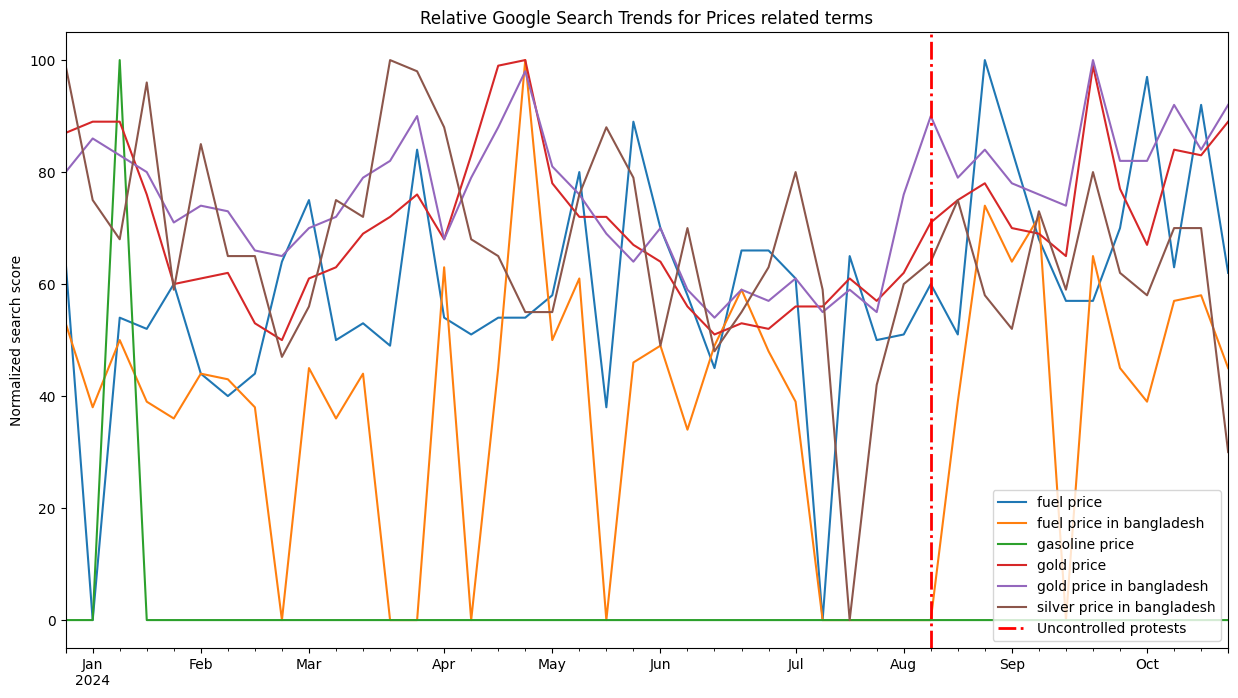

In [41]:
get_topic_charts(df, "Prices")

## Natural Disasters Related Terms

### Key Conclusions from Google Trends Data on Natural Disasters in Bangladesh (2024)

1. **Significant Spikes in Search Interest During Major Flood Events**: The data indicates notable increases in search activity corresponding to the major flood events in August and October 2024.Similarly, in October 2024, floods destroyed an estimated 1.1 million metric tons of rice, prompting increased public concern and information-seeking behavior.

2. **Elevated Interest in Specific Regions**: Search terms related to affected areas, such as "Feni floods" and "Cox's Bazar landslides," saw heightened activity during and after the natural disasters. This trend reflects the public's focus on regions severely impacted by events like the August floods, which led to significant displacement and infrastructure damage in districts including Feni and Cox's Bazar. 



C:\Users\Alexander\AppData\Local\Temp\ipykernel_42088\3208693226.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftemp.date = dftemp.date.apply(pd.to_datetime)


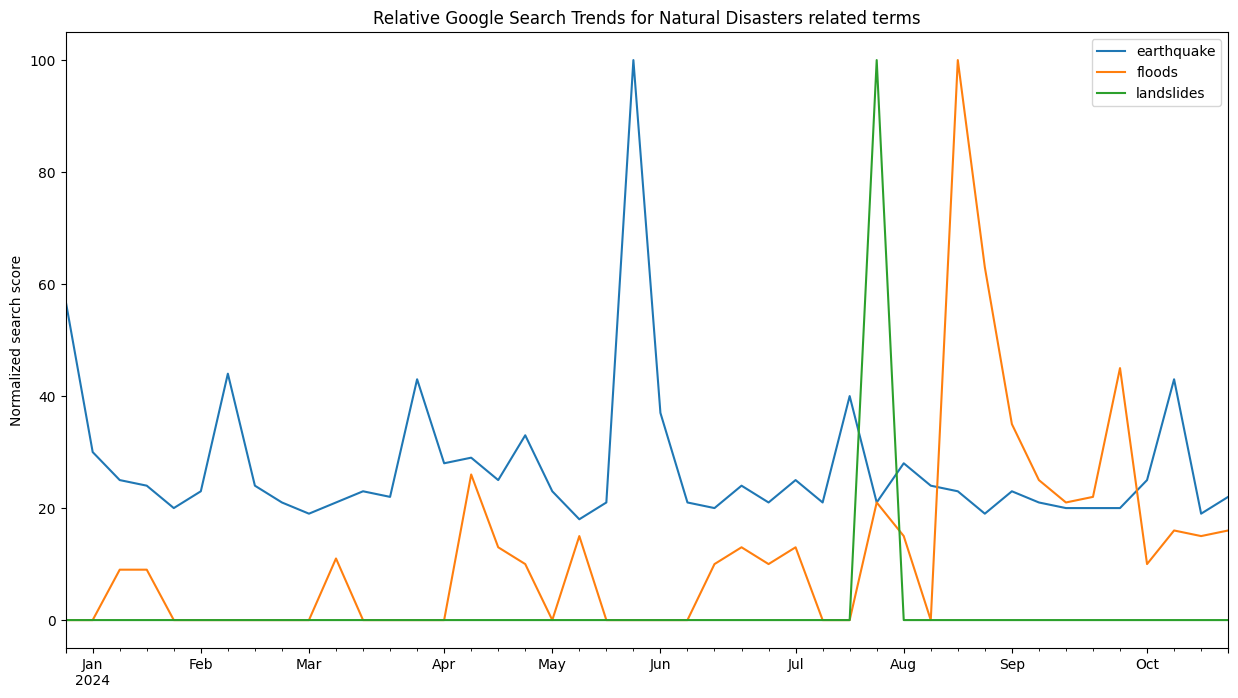

In [43]:
get_topic_charts(df, "Natural Disasters")

## Subanational Coverage

### What Does "Weeks with Valid Data" Mean?

1. Google Trends provides normalized search interest scores (0-100) for each term and week; a score of 0 means no measurable interest.
2. Weeks with valid data are those where the score (`value`) is greater than 0, indicating measurable public interest.
3. The code counts these valid weeks for each term and region to identify the consistency of interest over time.
4. Regions with higher counts of valid weeks show sustained or frequent interest in the given term.


In [45]:
shapefile_path = "../../data/bgd_admbnda_adm1_bbs_20201113/bgd_admbnda_adm1_bbs_20201113.shp"
gpf = gpd.read_file(shapefile_path)
gpf['ADM1_PCODE'] = gpf['ADM1_PCODE'].str.strip() 
gpf['ADM1_PCODE'] = gpf['ADM1_PCODE'].str.replace('\u200b', '')
print(gpf['ADM1_PCODE'].unique())

['BD10' 'BD20' 'BD30' 'BD40' 'BD45' 'BD50' 'BD55' 'BD60']


In [47]:
pcode_mapping = {
    'BD10': 'BD-A',  # Barisal
    'BD20': 'BD-B',  # Chittagong
    'BD30': 'BD-C',  # Dhaka
    'BD40': 'BD-D',  # Khulna
    'BD45': 'BD-H',  # Mymensingh
    'BD50': 'BD-E',  # Rajshahi
    'BD55': 'BD-F',  # Rangpur
    'BD60': 'BD-G'   # Sylhet
}

gpf['ADM1_PCODE'] = gpf['ADM1_PCODE'].map(pcode_mapping)

In [48]:
sub_dirs = [{'BD-A': 'Barisal'},
            {'BD-B': 'Chittagong'},
            {'BD-C': 'Dhaka'},
            {'BD-D': 'Khulna'},
            {'BD-H': 'Mymensingh'},
            {'BD-E': 'Rajshahi'},
            {'BD-F': 'Rangpur'},
            {'BD-G': 'Sylhet'}]

In [49]:
df = pd.DataFrame()
for geo in sub_dirs:
    for dicts in [forex_terms, deval_terms, price_terms, disaster_terms, conflict_terms, other_terms]:

        for topic, lis in dicts.items():
            for term in lis:
                filters = {
                            'terms': term,
                            'geoRestriction_region': list(geo.keys())[0],
                            'time_startDate': "2024-01-01",
                            #'time_endDate' : "2024-10-",
                            "timelineResolution" : "week"
                        }
                try:

                    r = google.get('getTimelinesForHealth', filters)

                    df_ = pd.DataFrame(r['lines'][0]['points'])
                    df_['term'] = term
                    df_['topic'] = topic
                    df_['geo'] = list(geo.keys())[0]

                    df = pd.concat([df, df_])

                except HttpError:
                    pass

In [50]:
gpf = gpf[gpf.ADM0_PCODE == 'BD']


con_map = {
    'Barisal': 'BD-A',
    'Chittagong': 'BD-B',
    'Dhaka': 'BD-C',
    'Khulna': 'BD-D',
    'Mymensingh': 'BD-H',
    'Rajshahi': 'BD-E',
    'Rangpur': 'BD-F',
    'Sylhet': 'BD-G'
}

gpf['ISO_S1'] = gpf.ADM1_EN.map(con_map)

In [51]:
count_temp = df[df.value != 0].groupby(['topic', 'term', 'geo'])['value'].count().reset_index()

### Key Conclusions from the Figures

1. **High Public Interest in Dhaka Across Topics**: Dhaka consistently shows the highest number of valid weeks for all three terms ("Sheikh Hasina," "student protest," and "GDP per capita"), indicating its central role in public discourse and economic focus.

2. **Regional Variations in Interest**: Interest in "Sheikh Hasina" is widespread across divisions, while "student protest" and "GDP per capita" are concentrated more in specific regions, reflecting localized concerns or issues.

3. **Limited Attention in Peripheral Divisions**: Divisions like Rangpur and Sylhet generally show fewer valid weeks, suggesting less search activity or lower relevance for these terms in these regions.


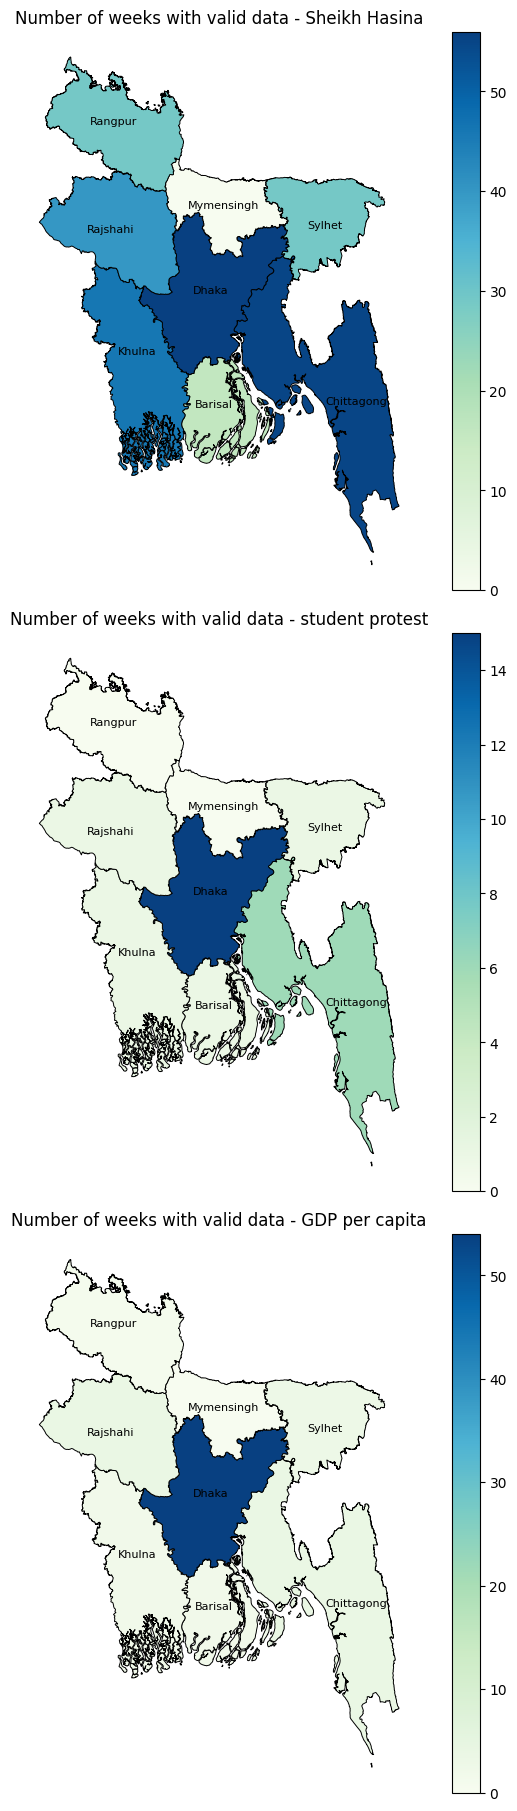

In [52]:
terms = ["Sheikh Hasina", "student protest", "GDP per capita"]


fig, axes = plt.subplots(nrows=len(terms), ncols=1, figsize=(8, len(terms) * 6), constrained_layout=True)

for ax, term in zip(axes, terms):

    sub_temp = count_temp.query(f"term == '{term}'")

    sub_temp = gpf.merge(sub_temp, left_on='ISO_S1', right_on='geo', how='left')

    sub_temp['value'] = sub_temp['value'].fillna(0)

    sub_temp = gpd.GeoDataFrame(sub_temp)

    sub_temp['coords'] = sub_temp['geometry'].apply(lambda x: x.representative_point().coords[:])
    sub_temp['coords'] = [coords[0] for coords in sub_temp['coords']]

    sub_temp.plot(column='value', cmap='GnBu', legend=True, edgecolor='k', linewidth=0.7, ax=ax)

    for idx, row in sub_temp.iterrows():
        ax.text(row.coords[0], row.coords[1], s=row['ADM1_EN'],
                horizontalalignment='center', fontsize=8, color='black')

    ax.axis('off')
    ax.set_title(f"Number of weeks with valid data - {term}", fontsize=12)

plt.show()

## Flourish Graph

### Explanation of the Flourish Graph Code

1. **Data Collection**: The code collects Google Trends data for various terms related to finance, business, law, health, and travel in Bangladesh from January to October 2024. The average search interest value for each term is calculated.

2. **Data Organization**: The data is structured in a DataFrame with columns for category, subcategory, term, and average search interest value (`Value`).

3. **Visualization with Plotly**: A sunburst chart is created using Plotly, showing hierarchical relationships between categories, subcategories, and individual terms, with the size of each segment proportional to its search interest value.

4. **Interactive Features**: The sunburst chart is interactive, allowing users to explore categories, subcategories, and terms visually, making it easier to analyze search trends in Bangladesh.


In [53]:
finance_terms = {"Finance": [{"Bank": ["bangladesh bank", "bank of bangladesh", "commercial bank",
                                       "bangladesh commercial bank", "commercial bank of bangladesh",
                                       "Sonali Bank PLC", "Janata Bank PLC","Agrani Bank PLC",
                                       "Rupali Bank PLC", "BRAC Bank PLC", "Dutch-Bangla Bank PLC",
                                       "Islami Bank Bangladesh PLC", "Standard Chartered Bank","Pubali Bank PLC",
                                       "bank rate today", "what is bank", "national bank of bangladesh",
                                       "today bank exchange rate", "bank account", "exchange rate today"
                                       ]},
                             {"Mobile banking": ["mobile banking app", "mobile banking code", "mobile banking app download",
                                                 "Sonali e-Wallet", "Janata mobile", "Islami mobile"]},
                             {"Currency": ["bangladesh currency", "currency exchange", "dollar", "dollar currency",
                                           "exchange rate", "euro currency", "foreign currency"
                                           ]}

                             ]}

business_terms = {"Business & industrial" : [{"Mining": ["what is mining", "bitcoin", "bitcoin mining", "mining in bangladesh",
                                                         "mining meaning", "crypto mining", "data mining", "gold mining", "usdt mining", "ton mining",
                                                         "cloud mining", "crypto mining app", "what is bitcoin mining", "what is data mining", "bitcoin mining app",
                                                         "what is bitcoin", "bitcoin mining free", "ton coin mining", "mining engineering", "free bitcoin mining"

                                            ]},
                                             {"Logistics": ["logistics management", "supply chain management", "logistics jobs", "what is logistics", "transport and logistics",
                                                            "logistics meaning", "ministry of transport and logistics", "inbound logistics"

                                             ]},
                                             {"Media": ["social media", "what is media", "ATN Bangla", "Prothom Alo"

                                             ]},
                                             {"Communication": ["what is communication", "communication skills", "business communication", "data communication", "effective communication", "communication english",
                                                                "communication technology", "communication media", "types of communication", "information", "communication meaning", "wireless communication", "communication process", "communication skill",
                                                                "health communication", "mobile communication", "verbal communication", "process of communication", "define communication", "type of communication",
                                                                "meaning of communication", "communication barriers", "good communication", "communication skills pdf", "business communication pdf"
                                             ]},

                                             {"Technology": ["science", "what is technology", "science and technology", "information technology", "emerging technology", "digital technology",
                                                             "new technology", "Bangladesh University of Engineering and Technology", "International University of Business Agriculture and Technology",
                                                             "ai technology", "define technology", "blockchain technology", "what is computer", "what is digital technology", "computer science",
                                                             "advantage of technology", "educational technology", "information communication technology", "ministry of innovation and technology"
                                                             ]
                                              }]}

law_terms = {"Law & Government" : [{"Ethics": ["what is ethics", "professional ethics", "morality", "business ethics", "virtue ethics", "ethics and morality",
                                               "ethics meaning", "code of ethics", "medical ethics", "health ethics", "research ethics", "work ethics",
                                               "principles of ethics", "what is the difference between", "normative ethics", "types of ethics", "ethics example",
                                               "what is ethics pdf", "define ethics", "environmental ethics", "what is morality", "applied ethics", "nursing ethics", "what is virtue ethics",
                                               "difference between ethics and morality"]},
                                   {"Rights": ["human rights", "what is rights", "human rights in bangladesh", "what is human rights", "all", "human rights law",
                                               "2024", "what are human rights", "reserved", "civil rights", "all rights reserved", "democratic rights",
                                               "copyright", "bangladeshi human rights commission", "international human rights law", " what is human right",
                                               "human rights watch", "sexual rights", "intellectual property rights", "intellectual property", "features of human rights",
                                               "examples of human rights", "importance of human rights", "universal declaration of human rights"]},
                                   {"Corporation": ["bangladeshi broadcasting corporation", "BEXIMCO Group", "Bashundhara Group", "Meghna Group of Industries", "Square Group","ACI Limited", "Pran-RFL Group",
                                                "Abul Khair Group", "City Group", "Transcom Group", "Akij Group", "T K Group of Industries","Ananda Group","Partex Group","Rahimafrooz Group","LafargeHolcim Bangladesh Limited","Grameenphone", "Robi Axiata Limited",
                                                "Summit Group", "United Group", "Olympic Industries Limited"]},
                                   {"War": ["world war", "israel", "israel war", "ukraine war", "russia war", "what is war", "war news", "russia ukraine war", "russia ukraine",
                                            "civil war", "war in bangladesh", "bangladesh war", "war movies", "god of war", "cold war", "first world war", "world war 2",
                                            "russia news", "russia war news", "Rohingya Refugee Crisis"]
                                    }]}

health_terms = {"Health" : [{"Nursing": ["nursing diagnosis", "nursing care plan", "what is nursing", "nursing process", "surgical nursing", "medical surgical nursing", "nursing questions and answers",
                                         "nursing assessment", "nanda", "nanda nursing diagnosis", "nursing research", "clinical nursing", "nursing school", "medical surgical nursing pdf", "nursing care plan pdf",
                                         "nursing intervention", "nursing home", "nursing ethics", "pediatric nursing", "nursing process pdf", "basic nursing", "nursing procedure", "what is nursing pdf"]},
                            {"Nutrition": ["nutrition food", "nutrition pdf", "what is nutrition", "nutrition jobs", "human nutrition", "nutrition security", "food science and nutrition", "nutrition ppt",
                                           "animal nutrition", "malnutrition", "nutrition international", "nutrition meaning", "loza nutrition", "milk nutrition", "avocado nutrition", "banana nutrition",
                                           "ethio fitness and nutrition", "maternal and child nutrition", "oats nutrition", "health and nutrition", "nutrition officer", "community nutrition", "nutrition exam",
                                           "oats", "types of nutrition", "peanut", "beans nutrition", "potato nutrition"]},
                            {"Skin": ["what is skin", "dry skin", "skin care", "skin disease", "skin infection", "cerave", "acne", "skin rash", "moisturizer", "skin type",
                                      "skin cancer", "sensitive skin", "itchy skin", "skin allergy", "sunscreen for oily skin", "types of skin", "skin tone", "skin itching",
                                      "skin diseases", "cerave for oily skin", "cerave cleanser", "vitamin c", "vitamin e" ]
                             }]}

travel_terms = {"Travel": [{"Airline": ["bangladeshi airline", "bangladesh airline", "bangladesh vacancy", "bangladesh airline result", "bangladesh airline vacancy", "airline booking", "bangladesh airline phone number",
                                        "bangladeshi airlines ticket", "bangladesh airline ticket", "airline tickets", "bangladeshi airline booking", "bangladeshi airline vacancy result", "indian airline", "indian airline app"]},
                           {"Airport": ["Hazrat Shahjalal International Airport","Shah Amanat International Airport", "Osmani International Airport", "Cox's Bazar Airport", "Jessore Airport", "Saidpur Airport", "Barisal Airport",
                                        "airport ticket", "indian airport", "airport vacancy"]},
                           {"Flight": ["bangladeshi flight", "airlines", "bangladeshi airlines flight", "flight status", "flight ticket", "flight tracker", "flight radar", "bangladeshi airlines flight schedule", "booking flight",
                                       "flight booking", "google flight", "bangladeshi airlines ticket", "book flight", "flight check", "flight radar 24", "cheap flight", "bangladeshi airlines ticket price" , "bangladeshi airlines flight booking"]},
                           {"Driving": ["driving license", "car driving", "driving license", "driving test", "driving license in bangladesh", "car games", "car driving games", "international driving license", "manual car driving",
                                        "driving license test", "driving license check online", "city car driving", "check driving license number online", "car driving training"]},
                           {"Hotels": ["Pan Pacific Sonargaon Dhaka", "The Westin Dhaka", "Radisson Blu Dhaka Water Garden","InterContinental Dhaka", "Le Méridien Dhaka","Six Seasons Hotel","Hotel Sarina Dhaka","Amari Dhaka","Sayeman Beach Resort",
                                        "Dusai Resort & Spa", "best hotels in dhaka", "hotels in dhaka", "booking", "cheap hotels in dhaka"]
                            }]}

In [54]:
df = pd.DataFrame()


for dicts in [finance_terms, business_terms, law_terms, health_terms, travel_terms]:
    for category, subcategories in dicts.items():
        for subcategory_dict in subcategories:
            for subcategory, terms in subcategory_dict.items():
                for term in terms:
                    filters = {
                        'terms': term,
                        'restrictions_geo': "BD",  
                        'restrictions_startDate': "2024-01",  
                        'restrictions_endDate': "2024-10"  
                    }

                    try:
                        result = google.get('getGraph', filters)

                        value = sum(point['value'] for point in result['lines'][0]['points']) / len(result['lines'][0]['points'])

                        df = pd.concat(
                            [df, pd.DataFrame({
                                'Category': [category],
                                'Subcategory': [subcategory],
                                'Term': [term],
                                'Value': [value]
                            })],
                            ignore_index=True
                        )

                        print(f"Data obtained for {term} in {subcategory}.")
                    except Exception as e:
                        print(f"Error when processing {term} in {subcategory}: {e}")

print(df.head())

Data obtained for bangladesh bank in Bank.
Data obtained for bank of bangladesh in Bank.
Data obtained for commercial bank in Bank.
Data obtained for bangladesh commercial bank in Bank.
Data obtained for commercial bank of bangladesh in Bank.
Data obtained for Sonali Bank PLC in Bank.
Data obtained for Janata Bank PLC in Bank.
Data obtained for Agrani Bank PLC in Bank.
Data obtained for Rupali Bank PLC in Bank.
Data obtained for BRAC Bank PLC in Bank.
Data obtained for Dutch-Bangla Bank PLC in Bank.
Data obtained for Islami Bank Bangladesh PLC in Bank.
Data obtained for Standard Chartered Bank in Bank.
Data obtained for Pubali Bank PLC in Bank.
Data obtained for bank rate today in Bank.
Data obtained for what is bank in Bank.
Data obtained for national bank of bangladesh in Bank.
Data obtained for today bank exchange rate in Bank.
Data obtained for bank account in Bank.
Data obtained for exchange rate today in Bank.
Data obtained for mobile banking app in Mobile banking.
Data obtained 

Finally, we visualizes the hierarchical relationship between different categories, subcategories, and terms, with their corresponding values, in an interactive and visually appealing way. The chart helps to explore trends and patterns in the data for Bangladesh.

In [37]:
import plotly.express as px
import plotly.io as pio
from plotly.offline import init_notebook_mode

# Initialize notebook mode
init_notebook_mode(connected=True)

# Set the renderer
pio.renderers.default = "notebook"

fig = px.sunburst(
    df,
    path=['Category', 'Subcategory', 'Term'],  
    values='Value',  
    color='Category',  
    title='Flourish interactive of Bangladesh'
)

fig.update_layout(
    width=800,  
    height=600  
)

fig.show()